# Pix2Pix

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="1"

### Load Dataset

In [3]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

--2021-11-27 13:25:13--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  2.58MB/s    in 15s     

2021-11-27 13:25:29 (1.94 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [4]:
!tar -xvzf facades.tar.gz

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades/test/19.jpg
facades/test/2.jpg
facades/test/20.jpg
facades/test/21.jpg
facades/test/22.jpg
facades/test/23.jpg
facades/test/24.jpg
facades/test/25.jpg
facades/test/26.jpg
facades/test/50.jpg
facades/test/51.jpg
facades/test/52.jpg
facades/test/53.jpg
facades/test/54.jpg
facades/test/55.jpg
facades/test/56.jpg
facades/test/57.jpg
facades/test/58.jpg
facades/test/59.jpg
facades/test/6.jpg
facades/test/60.jpg
facades/test/61.jpg
facades/test/62.jpg
facades/test/63.jpg
facades/test/64.jpg
facades/test/65.jpg
facades/test/66.jpg
facades/test/67.jpg
facades/test/6

In [5]:
print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/train/'))[2]))
print("평가 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/val/'))[2]))
print("테스트 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/test/'))[2]))

학습 데이터셋 A와 B의 개수: 400
평가 데이터셋 A와 B의 개수: 100
테스트 데이터셋 A와 B의 개수: 106


이미지 크기: (512, 256)


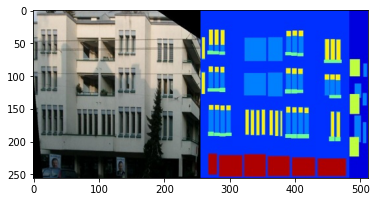

In [6]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./facades/train/1.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

### 커스텀 데이터 셋

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg"))
        # 데이터의 개수가 적기 때문에 테스트 데이터를 학습 시기에 사용
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg")))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반

        # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [12]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("facades", transforms_=transforms_)
val_dataset = ImageDataset("facades", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=1)

### 생정자(Generator) 및 판별자(Discriminator) Model
- Pix2Pix는 cGAN 구조를 가지며, 이미지를 조건(condition)으로 입력받아 이미지를 출력
    - 입력 차원과 출력 차원이 동일한 아키텍처로 U-Net를 사용

In [13]:
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

### 모델 학습 및 샘플링 
- 학습을 위해 생성자와 판별자 모델을 초기화
- 적절한 하이퍼 파라미터를 설정
    - Pix2Pix는 L1 loss를 이용해 출력 이미지가 ground-truth와 유사해질 수 있도록 한다.

In [14]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 200 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd02fac8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 0/200] [D loss: 0.279326] [G pixel loss: 0.292284, adv loss: 0.5882025361061096] [Elapsed time: 5.80s]
[Epoch 1/200] [D loss: 0.156442] [G pixel loss: 0.314905, adv loss: 0.7372868061065674] [Elapsed time: 10.81s]
[Epoch 2/200] [D loss: 0.107643] [G pixel loss: 0.334154, adv loss: 1.0419740676879883] [Elapsed time: 15.84s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 3/200] [D loss: 0.113322] [G pixel loss: 0.399992, adv loss: 1.0578069686889648] [Elapsed time: 21.69s]
[Epoch 4/200] [D loss: 0.095743] [G pixel loss: 0.325300, adv loss: 0.9589096307754517] [Elapsed time: 26.74s]
[Epoch 5/200] [D loss: 0.069012] [G pixel loss: 0.272253, adv loss: 0.6597460508346558] [Elapsed time: 31.83s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 6/200] [D loss: 0.108954] [G pixel loss: 0.325073, adv loss: 0.8041973114013672] [Elapsed time: 37.68s]
[Epoch 7/200] [D loss: 0.029081] [G pixel loss: 0.330202, adv loss: 0.8863396048545837] [Elapsed time: 42.73s]
[Epoch 8/200] [D loss: 0.040693] [G pixel loss: 0.283927, adv loss: 1.0186833143234253] [Elapsed time: 47.78s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

[Epoch 9/200] [D loss: 0.046428] [G pixel loss: 0.286535, adv loss: 0.9596642255783081] [Elapsed time: 53.60s]
[Epoch 10/200] [D loss: 0.165100] [G pixel loss: 0.308720, adv loss: 0.37747570872306824] [Elapsed time: 58.65s]
[Epoch 11/200] [D loss: 0.030704] [G pixel loss: 0.283380, adv loss: 0.8699047565460205] [Elapsed time: 63.70s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004c18>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 12/200] [D loss: 0.033330] [G pixel loss: 0.314510, adv loss: 0.942760169506073] [Elapsed time: 69.60s]
[Epoch 13/200] [D loss: 0.081383] [G pixel loss: 0.342505, adv loss: 0.8252550363540649] [Elapsed time: 74.67s]
[Epoch 14/200] [D loss: 0.021497] [G pixel loss: 0.300384, adv loss: 0.9407318830490112] [Elapsed time: 79.73s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd0047f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 15/200] [D loss: 0.073238] [G pixel loss: 0.299876, adv loss: 0.7734717130661011] [Elapsed time: 85.64s]
[Epoch 16/200] [D loss: 0.059227] [G pixel loss: 0.232797, adv loss: 0.6508050560951233] [Elapsed time: 90.67s]
[Epoch 17/200] [D loss: 0.083646] [G pixel loss: 0.346269, adv loss: 1.307050347328186] [Elapsed time: 95.73s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004c18>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 18/200] [D loss: 0.117773] [G pixel loss: 0.350825, adv loss: 0.4168160557746887] [Elapsed time: 101.60s]
[Epoch 19/200] [D loss: 0.174128] [G pixel loss: 0.320059, adv loss: 0.2627235949039459] [Elapsed time: 106.66s]
[Epoch 20/200] [D loss: 0.062721] [G pixel loss: 0.268759, adv loss: 0.8243903517723083] [Elapsed time: 111.71s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 21/200] [D loss: 0.034364] [G pixel loss: 0.342665, adv loss: 0.8858213424682617] [Elapsed time: 117.54s]
[Epoch 22/200] [D loss: 0.027715] [G pixel loss: 0.370939, adv loss: 1.0356855392456055] [Elapsed time: 122.61s]
[Epoch 23/200] [D loss: 0.111190] [G pixel loss: 0.262758, adv loss: 0.5225070118904114] [Elapsed time: 127.66s]
[Epoch 24/200] [D loss: 0.144768] [G pixel loss: 0.279976, adv loss: 0.31482088565826416] [Elapsed time: 132.74s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 25/200] [D loss: 0.093025] [G pixel loss: 0.278997, adv loss: 0.9577770233154297] [Elapsed time: 138.56s]
[Epoch 26/200] [D loss: 0.044729] [G pixel loss: 0.325844, adv loss: 1.4964046478271484] [Elapsed time: 143.63s]
[Epoch 27/200] [D loss: 0.035645] [G pixel loss: 0.352646, adv loss: 1.3455153703689575] [Elapsed time: 148.70s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 28/200] [D loss: 0.173237] [G pixel loss: 0.294442, adv loss: 1.2435181140899658] [Elapsed time: 154.57s]
[Epoch 29/200] [D loss: 0.020539] [G pixel loss: 0.274455, adv loss: 0.9340016841888428] [Elapsed time: 159.65s]
[Epoch 30/200] [D loss: 0.021712] [G pixel loss: 0.379506, adv loss: 1.2277610301971436] [Elapsed time: 164.77s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 31/200] [D loss: 0.249625] [G pixel loss: 0.261656, adv loss: 0.17011886835098267] [Elapsed time: 170.65s]
[Epoch 32/200] [D loss: 0.051635] [G pixel loss: 0.247216, adv loss: 0.6332114934921265] [Elapsed time: 175.73s]
[Epoch 33/200] [D loss: 0.010833] [G pixel loss: 0.243995, adv loss: 0.967736005783081] [Elapsed time: 180.83s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 34/200] [D loss: 0.024880] [G pixel loss: 0.254171, adv loss: 0.7413305640220642] [Elapsed time: 186.70s]
[Epoch 35/200] [D loss: 0.010579] [G pixel loss: 0.243578, adv loss: 0.9981232285499573] [Elapsed time: 191.79s]
[Epoch 36/200] [D loss: 0.020178] [G pixel loss: 0.345718, adv loss: 1.102247953414917] [Elapsed time: 196.92s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004c88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 37/200] [D loss: 0.147539] [G pixel loss: 0.246214, adv loss: 1.219490647315979] [Elapsed time: 202.82s]
[Epoch 38/200] [D loss: 0.035222] [G pixel loss: 0.218600, adv loss: 0.7305996417999268] [Elapsed time: 207.90s]
[Epoch 39/200] [D loss: 0.055957] [G pixel loss: 0.226077, adv loss: 1.1125298738479614] [Elapsed time: 212.98s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004c88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 40/200] [D loss: 0.052197] [G pixel loss: 0.267911, adv loss: 0.7308882474899292] [Elapsed time: 218.86s]
[Epoch 41/200] [D loss: 0.070417] [G pixel loss: 0.207657, adv loss: 0.828574538230896] [Elapsed time: 223.95s]
[Epoch 42/200] [D loss: 0.021263] [G pixel loss: 0.223332, adv loss: 0.9579658508300781] [Elapsed time: 229.04s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd004e80>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 43/200] [D loss: 0.017933] [G pixel loss: 0.184215, adv loss: 1.144639492034912] [Elapsed time: 234.96s]
[Epoch 44/200] [D loss: 0.018601] [G pixel loss: 0.226302, adv loss: 0.8283736705780029] [Elapsed time: 240.04s]
[Epoch 45/200] [D loss: 0.011959] [G pixel loss: 0.233299, adv loss: 1.1479512453079224] [Elapsed time: 245.12s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcd0045c0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 46/200] [D loss: 0.024057] [G pixel loss: 0.303243, adv loss: 0.9755328297615051] [Elapsed time: 251.07s]
[Epoch 47/200] [D loss: 0.032503] [G pixel loss: 0.200841, adv loss: 0.7861980199813843] [Elapsed time: 256.14s]
[Epoch 48/200] [D loss: 0.008001] [G pixel loss: 0.245479, adv loss: 0.9133015871047974] [Elapsed time: 261.25s]
[Epoch 49/200] [D loss: 0.006797] [G pixel loss: 0.254230, adv loss: 1.014568567276001] [Elapsed time: 266.34s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb65c0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 50/200] [D loss: 0.021806] [G pixel loss: 0.266197, adv loss: 0.7816124558448792] [Elapsed time: 272.21s]
[Epoch 51/200] [D loss: 0.020993] [G pixel loss: 0.198129, adv loss: 1.1772043704986572] [Elapsed time: 277.31s]
[Epoch 52/200] [D loss: 0.017420] [G pixel loss: 0.261591, adv loss: 1.0440895557403564] [Elapsed time: 282.42s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 53/200] [D loss: 0.021301] [G pixel loss: 0.300060, adv loss: 1.1185731887817383] [Elapsed time: 288.29s]
[Epoch 54/200] [D loss: 0.018886] [G pixel loss: 0.200949, adv loss: 0.8385738134384155] [Elapsed time: 293.36s]
[Epoch 55/200] [D loss: 0.013371] [G pixel loss: 0.314619, adv loss: 0.8450369238853455] [Elapsed time: 298.45s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 56/200] [D loss: 0.023492] [G pixel loss: 0.239146, adv loss: 0.8482808470726013] [Elapsed time: 304.29s]
[Epoch 57/200] [D loss: 0.017410] [G pixel loss: 0.171618, adv loss: 0.9056195020675659] [Elapsed time: 309.36s]
[Epoch 58/200] [D loss: 0.027754] [G pixel loss: 0.174643, adv loss: 0.8053725957870483] [Elapsed time: 314.48s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6be0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 59/200] [D loss: 0.011291] [G pixel loss: 0.322176, adv loss: 1.1599209308624268] [Elapsed time: 320.33s]
[Epoch 60/200] [D loss: 0.009465] [G pixel loss: 0.259219, adv loss: 0.9257485866546631] [Elapsed time: 325.40s]
[Epoch 61/200] [D loss: 0.010108] [G pixel loss: 0.226089, adv loss: 0.8838421106338501] [Elapsed time: 330.48s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 62/200] [D loss: 0.010188] [G pixel loss: 0.194082, adv loss: 0.8291733860969543] [Elapsed time: 336.37s]
[Epoch 63/200] [D loss: 0.010082] [G pixel loss: 0.261605, adv loss: 1.1050714254379272] [Elapsed time: 341.48s]
[Epoch 64/200] [D loss: 0.005572] [G pixel loss: 0.275961, adv loss: 1.008471965789795] [Elapsed time: 346.57s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6ef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 65/200] [D loss: 0.010638] [G pixel loss: 0.190787, adv loss: 0.9570180177688599] [Elapsed time: 352.43s]
[Epoch 66/200] [D loss: 0.005349] [G pixel loss: 0.269014, adv loss: 1.0462512969970703] [Elapsed time: 357.52s]
[Epoch 67/200] [D loss: 0.007460] [G pixel loss: 0.248639, adv loss: 0.9853582978248596] [Elapsed time: 362.62s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 68/200] [D loss: 0.004547] [G pixel loss: 0.187980, adv loss: 0.9393100142478943] [Elapsed time: 368.50s]
[Epoch 69/200] [D loss: 0.003598] [G pixel loss: 0.187925, adv loss: 1.0659430027008057] [Elapsed time: 373.59s]
[Epoch 70/200] [D loss: 0.007246] [G pixel loss: 0.155814, adv loss: 1.061730146408081] [Elapsed time: 378.67s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6e10>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 71/200] [D loss: 0.043218] [G pixel loss: 0.155942, adv loss: 1.166837453842163] [Elapsed time: 384.54s]
[Epoch 72/200] [D loss: 0.026461] [G pixel loss: 0.217470, adv loss: 0.7301280498504639] [Elapsed time: 389.63s]
[Epoch 73/200] [D loss: 0.300535] [G pixel loss: 0.196212, adv loss: 0.6495890021324158] [Elapsed time: 394.71s]
[Epoch 74/200] [D loss: 0.110541] [G pixel loss: 0.236458, adv loss: 0.49410101771354675] [Elapsed time: 399.80s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 75/200] [D loss: 0.041814] [G pixel loss: 0.174295, adv loss: 1.276768684387207] [Elapsed time: 405.69s]
[Epoch 76/200] [D loss: 0.190613] [G pixel loss: 0.219028, adv loss: 0.7242900133132935] [Elapsed time: 410.76s]
[Epoch 77/200] [D loss: 0.011333] [G pixel loss: 0.229965, adv loss: 1.1731891632080078] [Elapsed time: 415.84s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6f60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 78/200] [D loss: 0.104696] [G pixel loss: 0.178370, adv loss: 0.5595987439155579] [Elapsed time: 421.71s]
[Epoch 79/200] [D loss: 0.017756] [G pixel loss: 0.203777, adv loss: 0.7259854078292847] [Elapsed time: 426.82s]
[Epoch 80/200] [D loss: 0.016386] [G pixel loss: 0.249134, adv loss: 0.8086587190628052] [Elapsed time: 431.91s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 81/200] [D loss: 0.003298] [G pixel loss: 0.166630, adv loss: 0.9861831665039062] [Elapsed time: 437.79s]
[Epoch 82/200] [D loss: 0.008135] [G pixel loss: 0.189848, adv loss: 0.923575758934021] [Elapsed time: 442.88s]
[Epoch 83/200] [D loss: 0.011015] [G pixel loss: 0.172391, adv loss: 0.9974417090415955] [Elapsed time: 447.97s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb65f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 84/200] [D loss: 0.007624] [G pixel loss: 0.204783, adv loss: 0.975077748298645] [Elapsed time: 453.86s]
[Epoch 85/200] [D loss: 0.003978] [G pixel loss: 0.221775, adv loss: 1.046776294708252] [Elapsed time: 458.93s]
[Epoch 86/200] [D loss: 0.003251] [G pixel loss: 0.186603, adv loss: 0.9881246089935303] [Elapsed time: 464.00s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6668>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 87/200] [D loss: 0.003589] [G pixel loss: 0.162161, adv loss: 1.0117061138153076] [Elapsed time: 469.94s]
[Epoch 88/200] [D loss: 0.004010] [G pixel loss: 0.231792, adv loss: 1.077298641204834] [Elapsed time: 475.04s]
[Epoch 89/200] [D loss: 0.006503] [G pixel loss: 0.201267, adv loss: 0.9861117601394653] [Elapsed time: 480.11s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 90/200] [D loss: 0.003904] [G pixel loss: 0.201185, adv loss: 0.984942615032196] [Elapsed time: 486.13s]
[Epoch 91/200] [D loss: 0.023613] [G pixel loss: 0.215416, adv loss: 0.9910374879837036] [Elapsed time: 491.22s]
[Epoch 92/200] [D loss: 0.002860] [G pixel loss: 0.251526, adv loss: 0.9686979055404663] [Elapsed time: 496.31s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6e48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

[Epoch 93/200] [D loss: 0.001802] [G pixel loss: 0.215288, adv loss: 0.9980999231338501] [Elapsed time: 502.19s]
[Epoch 94/200] [D loss: 0.002260] [G pixel loss: 0.205743, adv loss: 0.995721161365509] [Elapsed time: 507.27s]
[Epoch 95/200] [D loss: 0.002219] [G pixel loss: 0.251409, adv loss: 1.0138981342315674] [Elapsed time: 512.39s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb6e10>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

[Epoch 96/200] [D loss: 0.002705] [G pixel loss: 0.169415, adv loss: 0.9466925859451294] [Elapsed time: 518.30s]
[Epoch 97/200] [D loss: 0.005867] [G pixel loss: 0.210128, adv loss: 0.9934709072113037] [Elapsed time: 523.39s]
[Epoch 98/200] [D loss: 0.002021] [G pixel loss: 0.194127, adv loss: 0.978763222694397] [Elapsed time: 528.48s]
[Epoch 99/200] [D loss: 0.002747] [G pixel loss: 0.259749, adv loss: 1.0306819677352905] [Elapsed time: 533.56s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb68d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 100/200] [D loss: 0.023101] [G pixel loss: 0.211506, adv loss: 0.8296080827713013] [Elapsed time: 539.50s]
[Epoch 101/200] [D loss: 0.005877] [G pixel loss: 0.255098, adv loss: 0.9688397645950317] [Elapsed time: 544.59s]
[Epoch 102/200] [D loss: 0.002715] [G pixel loss: 0.181614, adv loss: 0.9673265218734741] [Elapsed time: 549.70s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfeb64a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 103/200] [D loss: 0.002051] [G pixel loss: 0.159768, adv loss: 0.9885885119438171] [Elapsed time: 555.67s]
[Epoch 104/200] [D loss: 0.002416] [G pixel loss: 0.180878, adv loss: 0.9760869741439819] [Elapsed time: 560.75s]
[Epoch 105/200] [D loss: 0.004393] [G pixel loss: 0.152300, adv loss: 0.9245337843894958] [Elapsed time: 565.84s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9ef60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 106/200] [D loss: 0.002154] [G pixel loss: 0.168221, adv loss: 0.9983140230178833] [Elapsed time: 571.74s]
[Epoch 107/200] [D loss: 0.004023] [G pixel loss: 0.211235, adv loss: 0.9941773414611816] [Elapsed time: 576.82s]
[Epoch 108/200] [D loss: 0.009205] [G pixel loss: 0.177960, adv loss: 0.8650810718536377] [Elapsed time: 581.90s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9eeb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 109/200] [D loss: 0.019432] [G pixel loss: 0.185170, adv loss: 0.8600439429283142] [Elapsed time: 587.80s]
[Epoch 110/200] [D loss: 0.002272] [G pixel loss: 0.137270, adv loss: 1.0072895288467407] [Elapsed time: 592.90s]
[Epoch 111/200] [D loss: 0.001702] [G pixel loss: 0.247896, adv loss: 1.013131856918335] [Elapsed time: 598.00s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9eba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 112/200] [D loss: 0.001938] [G pixel loss: 0.198814, adv loss: 1.017568826675415] [Elapsed time: 603.95s]
[Epoch 113/200] [D loss: 0.010632] [G pixel loss: 0.148286, adv loss: 1.1837844848632812] [Elapsed time: 609.03s]
[Epoch 114/200] [D loss: 0.003162] [G pixel loss: 0.159631, adv loss: 1.069573163986206] [Elapsed time: 614.12s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9ef60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 115/200] [D loss: 0.002013] [G pixel loss: 0.175838, adv loss: 1.0110039710998535] [Elapsed time: 620.03s]
[Epoch 116/200] [D loss: 0.002128] [G pixel loss: 0.179718, adv loss: 1.0236709117889404] [Elapsed time: 625.10s]
[Epoch 117/200] [D loss: 0.002760] [G pixel loss: 0.208874, adv loss: 0.9603679180145264] [Elapsed time: 630.19s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e7b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 118/200] [D loss: 0.033854] [G pixel loss: 0.182921, adv loss: 0.7811228632926941] [Elapsed time: 636.12s]
[Epoch 119/200] [D loss: 0.039481] [G pixel loss: 0.195769, adv loss: 0.6628174781799316] [Elapsed time: 641.19s]
[Epoch 120/200] [D loss: 0.052760] [G pixel loss: 0.133892, adv loss: 1.003385066986084] [Elapsed time: 646.31s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9ec88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 121/200] [D loss: 0.010405] [G pixel loss: 0.177844, adv loss: 1.0367343425750732] [Elapsed time: 652.28s]
[Epoch 122/200] [D loss: 0.004075] [G pixel loss: 0.187339, adv loss: 0.9398595690727234] [Elapsed time: 657.35s]
[Epoch 123/200] [D loss: 0.004322] [G pixel loss: 0.166692, adv loss: 1.095812439918518] [Elapsed time: 662.44s]
[Epoch 124/200] [D loss: 0.007116] [G pixel loss: 0.222090, adv loss: 0.8961701393127441] [Elapsed time: 667.52s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e7b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 125/200] [D loss: 0.002053] [G pixel loss: 0.162838, adv loss: 0.9820810556411743] [Elapsed time: 673.45s]
[Epoch 126/200] [D loss: 0.001621] [G pixel loss: 0.163650, adv loss: 1.0018556118011475] [Elapsed time: 678.58s]
[Epoch 127/200] [D loss: 0.002005] [G pixel loss: 0.192599, adv loss: 1.027384638786316] [Elapsed time: 683.67s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9eda0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 128/200] [D loss: 0.003075] [G pixel loss: 0.173038, adv loss: 0.9854114055633545] [Elapsed time: 689.62s]
[Epoch 129/200] [D loss: 0.002724] [G pixel loss: 0.228693, adv loss: 1.009801983833313] [Elapsed time: 694.69s]
[Epoch 130/200] [D loss: 0.001391] [G pixel loss: 0.154090, adv loss: 0.9898685216903687] [Elapsed time: 699.77s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 131/200] [D loss: 0.001421] [G pixel loss: 0.176685, adv loss: 0.980419933795929] [Elapsed time: 705.69s]
[Epoch 132/200] [D loss: 0.001286] [G pixel loss: 0.185374, adv loss: 1.0448379516601562] [Elapsed time: 710.77s]
[Epoch 133/200] [D loss: 0.001775] [G pixel loss: 0.163023, adv loss: 0.995639979839325] [Elapsed time: 715.86s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e588>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 134/200] [D loss: 0.001103] [G pixel loss: 0.151722, adv loss: 0.9785082340240479] [Elapsed time: 721.76s]
[Epoch 135/200] [D loss: 0.001692] [G pixel loss: 0.217053, adv loss: 1.0064393281936646] [Elapsed time: 726.85s]
[Epoch 136/200] [D loss: 0.001906] [G pixel loss: 0.144607, adv loss: 1.0180528163909912] [Elapsed time: 731.91s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

[Epoch 137/200] [D loss: 0.001390] [G pixel loss: 0.204013, adv loss: 1.0056931972503662] [Elapsed time: 737.81s]
[Epoch 138/200] [D loss: 0.001725] [G pixel loss: 0.208138, adv loss: 1.026809573173523] [Elapsed time: 742.90s]
[Epoch 139/200] [D loss: 0.002126] [G pixel loss: 0.211173, adv loss: 1.0194642543792725] [Elapsed time: 747.99s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9edd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 140/200] [D loss: 0.002790] [G pixel loss: 0.132934, adv loss: 0.9689479470252991] [Elapsed time: 753.96s]
[Epoch 141/200] [D loss: 0.003371] [G pixel loss: 0.229134, adv loss: 1.0128390789031982] [Elapsed time: 759.05s]
[Epoch 142/200] [D loss: 0.001003] [G pixel loss: 0.134239, adv loss: 1.0117621421813965] [Elapsed time: 764.14s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9edd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 143/200] [D loss: 0.001466] [G pixel loss: 0.171414, adv loss: 0.9977227449417114] [Elapsed time: 770.11s]
[Epoch 144/200] [D loss: 0.000942] [G pixel loss: 0.149491, adv loss: 1.0082306861877441] [Elapsed time: 775.18s]
[Epoch 145/200] [D loss: 0.003498] [G pixel loss: 0.164805, adv loss: 1.0356121063232422] [Elapsed time: 780.27s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9ec88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 146/200] [D loss: 0.002435] [G pixel loss: 0.169512, adv loss: 0.9521150588989258] [Elapsed time: 786.20s]
[Epoch 147/200] [D loss: 0.003413] [G pixel loss: 0.223034, adv loss: 0.9965186715126038] [Elapsed time: 791.27s]
[Epoch 148/200] [D loss: 0.001681] [G pixel loss: 0.171515, adv loss: 0.9887017607688904] [Elapsed time: 796.34s]
[Epoch 149/200] [D loss: 0.001171] [G pixel loss: 0.173367, adv loss: 1.0377342700958252] [Elapsed time: 801.41s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9eda0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 150/200] [D loss: 0.002678] [G pixel loss: 0.118861, adv loss: 0.9407303333282471] [Elapsed time: 807.34s]
[Epoch 151/200] [D loss: 0.002650] [G pixel loss: 0.135702, adv loss: 1.0164023637771606] [Elapsed time: 812.41s]
[Epoch 152/200] [D loss: 0.007789] [G pixel loss: 0.157664, adv loss: 0.8768976926803589] [Elapsed time: 817.51s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9e780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 153/200] [D loss: 0.002237] [G pixel loss: 0.186607, adv loss: 0.9758344888687134] [Elapsed time: 823.42s]
[Epoch 154/200] [D loss: 0.001469] [G pixel loss: 0.210212, adv loss: 1.0474900007247925] [Elapsed time: 828.51s]
[Epoch 155/200] [D loss: 0.001347] [G pixel loss: 0.144292, adv loss: 0.9707520604133606] [Elapsed time: 833.59s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfe9eb38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 156/200] [D loss: 0.002953] [G pixel loss: 0.180505, adv loss: 0.9674122333526611] [Elapsed time: 839.55s]
[Epoch 157/200] [D loss: 0.003373] [G pixel loss: 0.151978, adv loss: 1.098764419555664] [Elapsed time: 844.61s]
[Epoch 158/200] [D loss: 0.003087] [G pixel loss: 0.164220, adv loss: 0.9178218841552734] [Elapsed time: 849.69s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 159/200] [D loss: 0.003940] [G pixel loss: 0.148710, adv loss: 1.0386207103729248] [Elapsed time: 855.60s]
[Epoch 160/200] [D loss: 0.001730] [G pixel loss: 0.157920, adv loss: 1.0481998920440674] [Elapsed time: 860.69s]
[Epoch 161/200] [D loss: 0.002601] [G pixel loss: 0.197048, adv loss: 0.9406429529190063] [Elapsed time: 865.79s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

[Epoch 162/200] [D loss: 0.001078] [G pixel loss: 0.169400, adv loss: 0.970245361328125] [Elapsed time: 871.69s]
[Epoch 163/200] [D loss: 0.015546] [G pixel loss: 0.171051, adv loss: 0.8064559698104858] [Elapsed time: 876.79s]
[Epoch 164/200] [D loss: 0.002019] [G pixel loss: 0.159492, adv loss: 0.9586374759674072] [Elapsed time: 881.85s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea27b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 165/200] [D loss: 0.002312] [G pixel loss: 0.145810, adv loss: 0.9344075918197632] [Elapsed time: 887.80s]
[Epoch 166/200] [D loss: 0.261145] [G pixel loss: 0.196838, adv loss: 0.29683631658554077] [Elapsed time: 892.87s]
[Epoch 167/200] [D loss: 0.251269] [G pixel loss: 0.136309, adv loss: 0.2952437400817871] [Elapsed time: 897.94s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 168/200] [D loss: 0.256938] [G pixel loss: 0.147435, adv loss: 0.2398126721382141] [Elapsed time: 903.85s]
[Epoch 169/200] [D loss: 0.165281] [G pixel loss: 0.131430, adv loss: 0.597554624080658] [Elapsed time: 908.94s]
[Epoch 170/200] [D loss: 0.085700] [G pixel loss: 0.192351, adv loss: 0.5186406373977661] [Elapsed time: 914.06s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2e10>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 171/200] [D loss: 0.014906] [G pixel loss: 0.159492, adv loss: 0.9652336835861206] [Elapsed time: 919.94s]
[Epoch 172/200] [D loss: 0.159187] [G pixel loss: 0.133695, adv loss: 0.6363359689712524] [Elapsed time: 925.01s]
[Epoch 173/200] [D loss: 0.047572] [G pixel loss: 0.176303, adv loss: 1.000401496887207] [Elapsed time: 930.09s]
[Epoch 174/200] [D loss: 0.005237] [G pixel loss: 0.158414, adv loss: 0.9694962501525879] [Elapsed time: 935.16s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 175/200] [D loss: 0.024303] [G pixel loss: 0.195922, adv loss: 1.3196269273757935] [Elapsed time: 941.10s]
[Epoch 176/200] [D loss: 0.020058] [G pixel loss: 0.154852, adv loss: 1.012701392173767] [Elapsed time: 946.19s]
[Epoch 177/200] [D loss: 0.005082] [G pixel loss: 0.209588, adv loss: 0.9962151646614075] [Elapsed time: 951.27s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 178/200] [D loss: 0.018105] [G pixel loss: 0.200290, adv loss: 0.8010900020599365] [Elapsed time: 957.15s]
[Epoch 179/200] [D loss: 0.025144] [G pixel loss: 0.157089, adv loss: 1.0126161575317383] [Elapsed time: 962.22s]
[Epoch 180/200] [D loss: 0.003462] [G pixel loss: 0.139827, adv loss: 1.0490858554840088] [Elapsed time: 967.29s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2940>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 181/200] [D loss: 0.004061] [G pixel loss: 0.143748, adv loss: 1.062315821647644] [Elapsed time: 973.18s]
[Epoch 182/200] [D loss: 0.006109] [G pixel loss: 0.184364, adv loss: 1.12932288646698] [Elapsed time: 978.25s]
[Epoch 183/200] [D loss: 0.021778] [G pixel loss: 0.152222, adv loss: 0.8978583812713623] [Elapsed time: 983.34s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea26d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 184/200] [D loss: 0.004268] [G pixel loss: 0.140224, adv loss: 0.9989004731178284] [Elapsed time: 989.25s]
[Epoch 185/200] [D loss: 0.005515] [G pixel loss: 0.186651, adv loss: 0.9469929337501526] [Elapsed time: 994.33s]
[Epoch 186/200] [D loss: 0.003046] [G pixel loss: 0.142171, adv loss: 1.072417140007019] [Elapsed time: 999.43s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2940>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 187/200] [D loss: 0.002029] [G pixel loss: 0.140017, adv loss: 1.039128065109253] [Elapsed time: 1005.37s]
[Epoch 188/200] [D loss: 0.001534] [G pixel loss: 0.146705, adv loss: 1.001474142074585] [Elapsed time: 1010.44s]
[Epoch 189/200] [D loss: 0.002862] [G pixel loss: 0.123252, adv loss: 0.9968142509460449] [Elapsed time: 1015.56s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 190/200] [D loss: 0.002314] [G pixel loss: 0.178115, adv loss: 0.9823181629180908] [Elapsed time: 1021.50s]
[Epoch 191/200] [D loss: 0.002285] [G pixel loss: 0.160020, adv loss: 1.0335612297058105] [Elapsed time: 1026.59s]
[Epoch 192/200] [D loss: 0.001329] [G pixel loss: 0.177905, adv loss: 0.9761825799942017] [Elapsed time: 1031.66s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea26d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 193/200] [D loss: 0.002107] [G pixel loss: 0.146636, adv loss: 1.0348434448242188] [Elapsed time: 1037.62s]
[Epoch 194/200] [D loss: 0.002231] [G pixel loss: 0.170521, adv loss: 0.9437311887741089] [Elapsed time: 1042.70s]
[Epoch 195/200] [D loss: 0.001473] [G pixel loss: 0.143753, adv loss: 0.9915072321891785] [Elapsed time: 1047.77s]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0fcfea2d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

[Epoch 196/200] [D loss: 0.002833] [G pixel loss: 0.116623, adv loss: 0.9947014451026917] [Elapsed time: 1053.71s]
[Epoch 197/200] [D loss: 0.002767] [G pixel loss: 0.171302, adv loss: 0.9642104506492615] [Elapsed time: 1058.79s]
[Epoch 198/200] [D loss: 0.001511] [G pixel loss: 0.163976, adv loss: 1.020155429840088] [Elapsed time: 1063.87s]
[Epoch 199/200] [D loss: 0.001982] [G pixel loss: 0.142544, adv loss: 0.9964475035667419] [Elapsed time: 1068.95s]


###### error
- RuntimeError: DataLoader worker (pid 5872) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
- docker 컨테이너를 띄울 때 디스크 용량을 공유하는데 메모리가 부족해서 발생하는 에러
- shm 사이즈가 컨테이너를 생성할 때 디폴트값이 64m 
###### 메모리 사용량 증가 
- 1ne : 컨테이너 이름
- --shm-size=400G : 용량 400G 설정

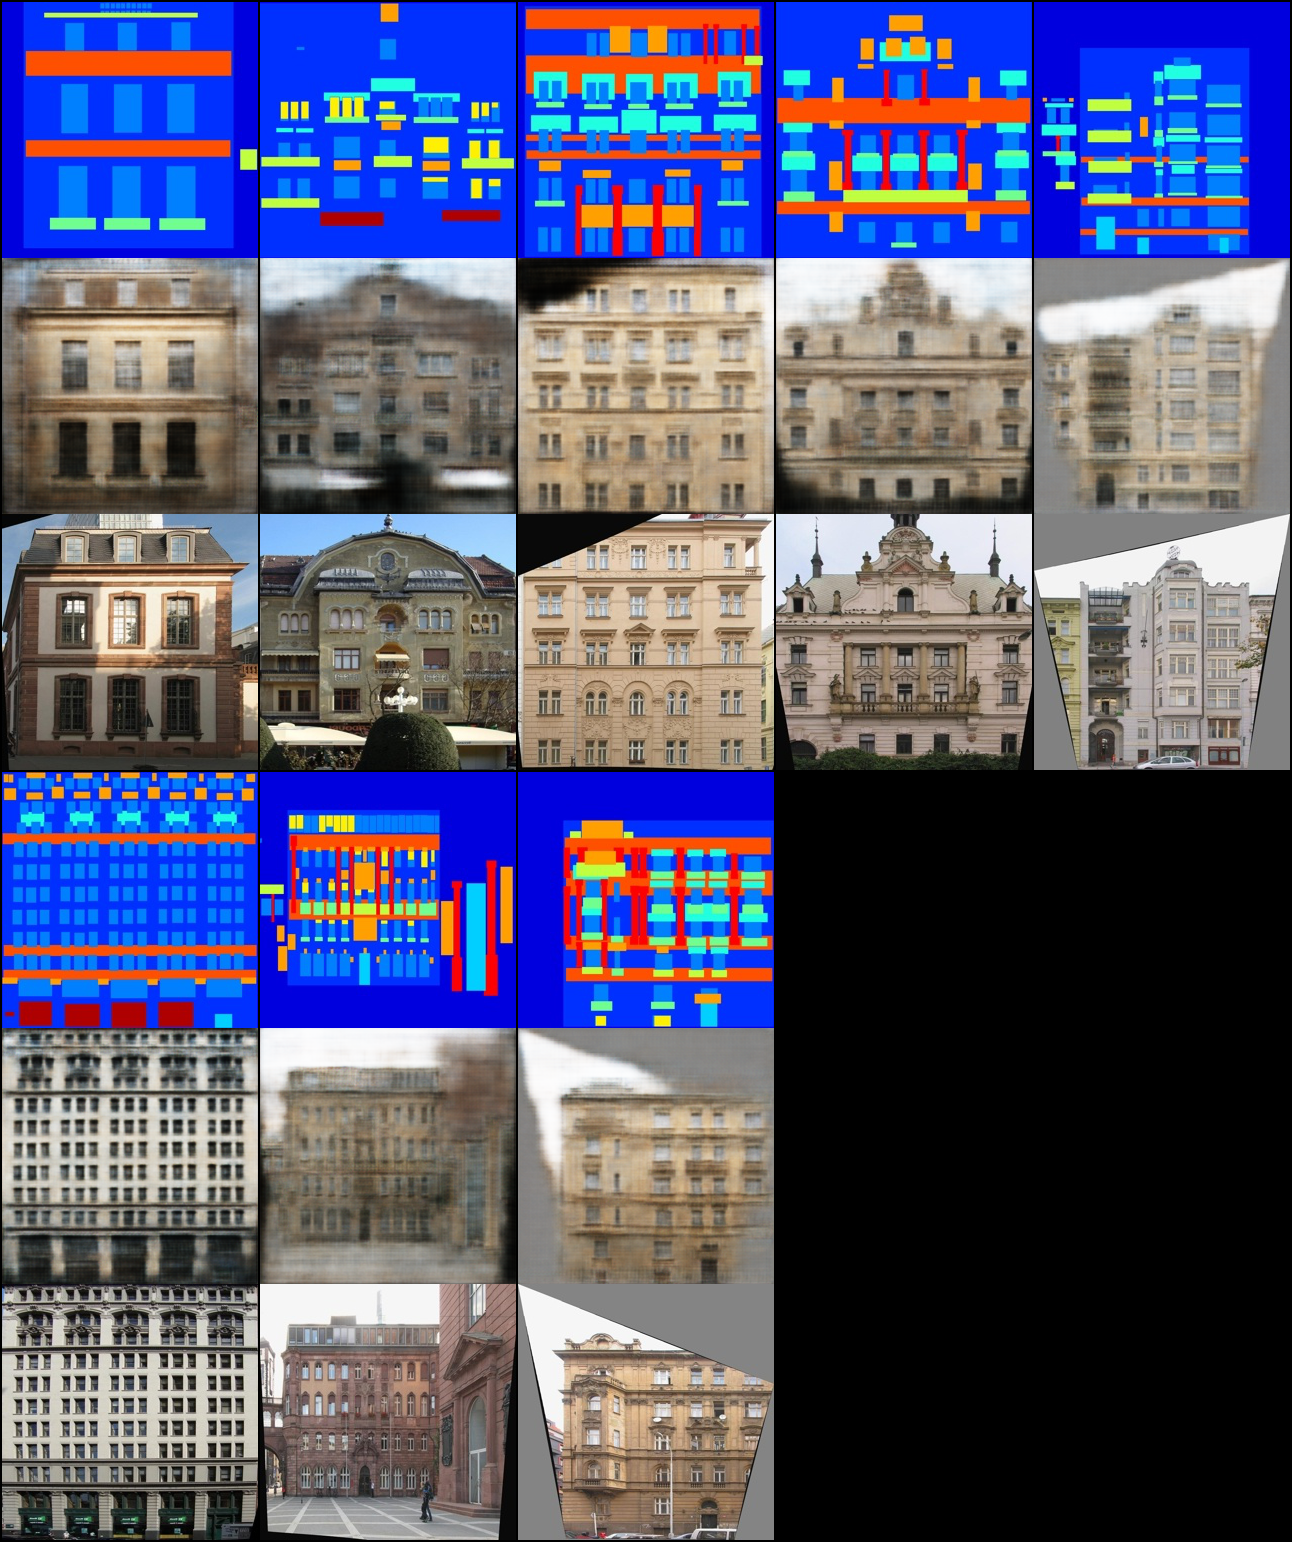

In [16]:
# 생성된 이미지 예시를 출력
from IPython.display import Image

Image('10000.png')

### 학습된 모델 파라미터 저장 및 테스트

In [17]:
# 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator_for_Facades.pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator_for_Facades.pt")
print("Model saved!")

Model saved!


In [18]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("Pix2Pix_Generator_for_Facades.pt"))
discriminator.load_state_dict(torch.load("Pix2Pix_Discriminator_for_Facades.pt"))

generator.eval();
discriminator.eval();

In [19]:
from PIL import Image

imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
real_A = imgs["B"].cuda()
real_B = imgs["A"].cuda()
fake_B = generator(real_A)
# real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
save_image(img_sample, f"result.png", nrow=5, normalize=True)

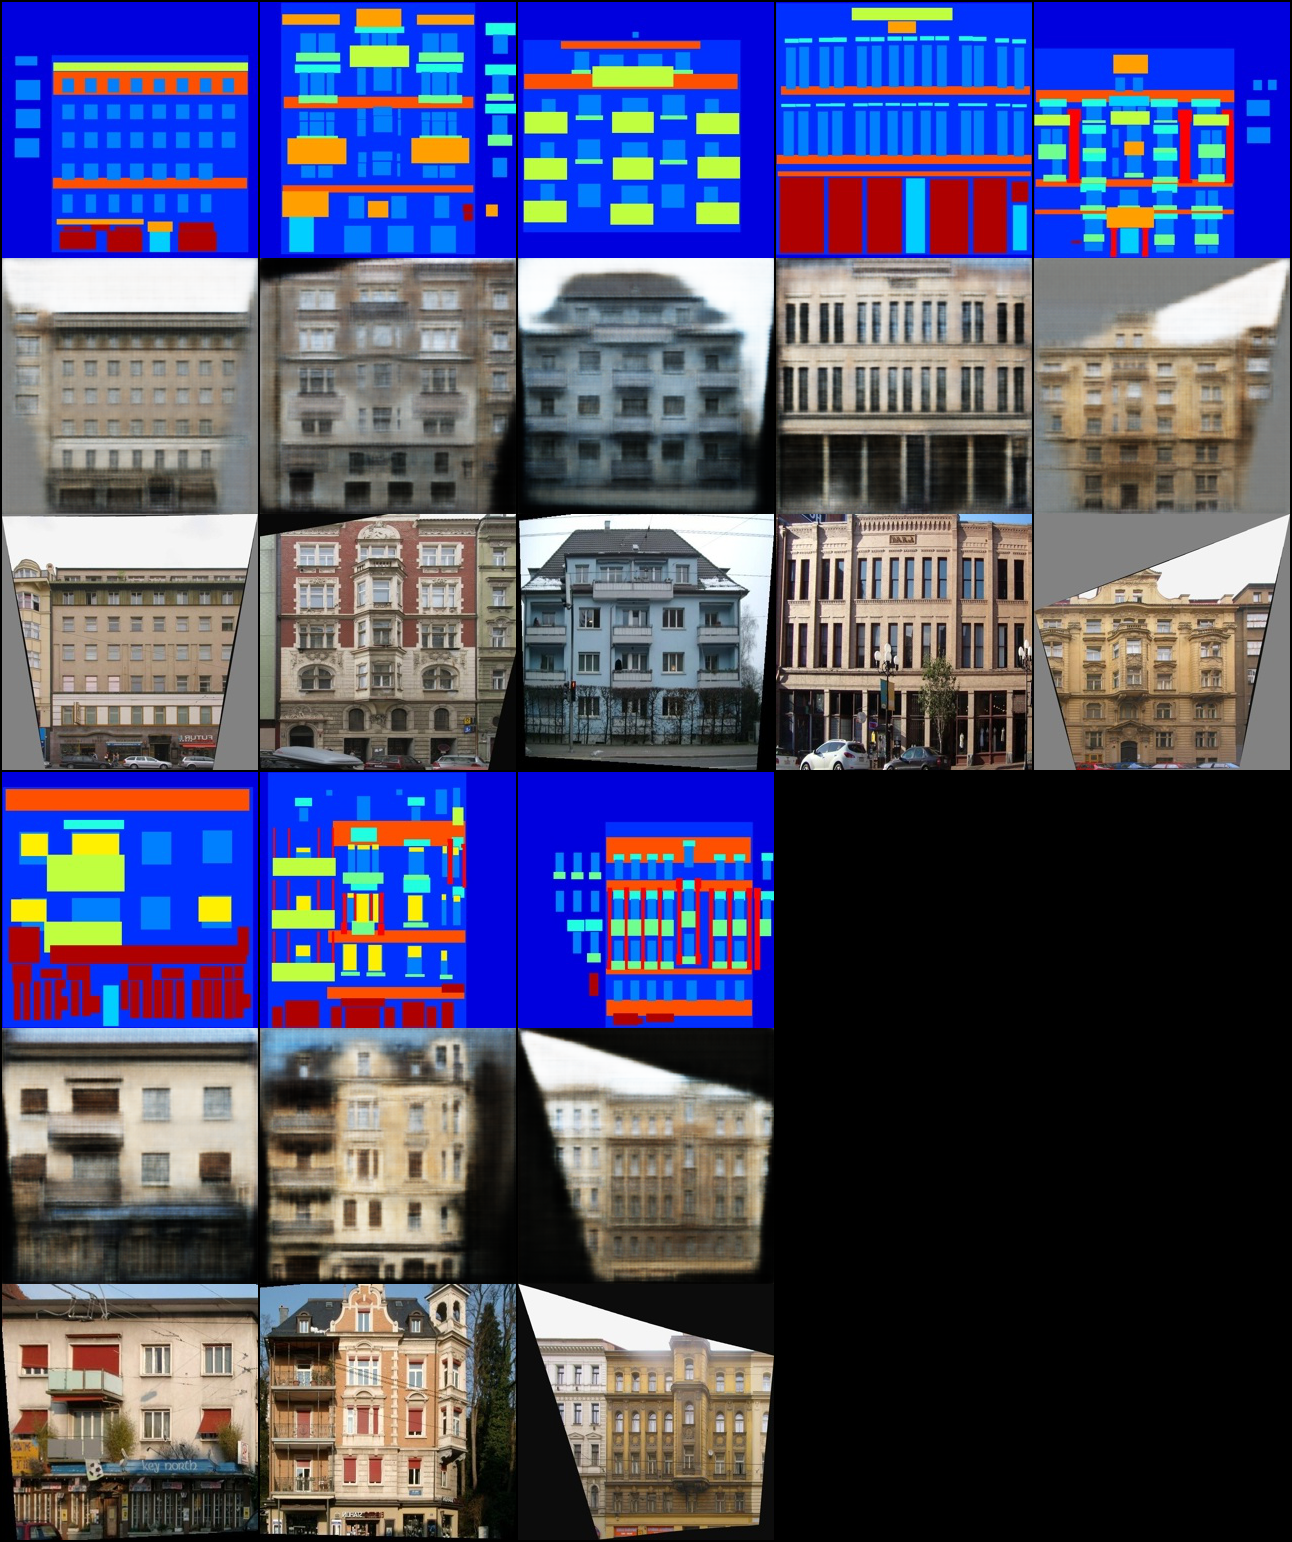

In [20]:
from IPython.display import Image

Image('result.png')